In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
from src.dataset import NeighborDataset
from torch.utils.data import DataLoader
from src.qpath import linspace_2D_equidistant
import numpy as np
import torch
from src.kernel import L_Kernel
from src.sqw import SpecNeuralRepr
import os

torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Only need to specify ckpt_path and synthetic data or not

For experimental data, used: "/pscratch/sd/z/zhantao/yuan/pscratch/sd/y/yn754/data/S2e/checkpoints/synthetic_nr2_bkw5e-04_tvw0e+00/kernel_model-epoch=22-val_loss=0.0000.ckpt"
For synthetic data, used: "/pscratch/sd/z/zhantao/yuan/pscratch/sd/y/yn754/data/S2e/checkpoints/synthetic_v1_nr3_bkw5e-03_tvw0e+00/kernel_model-epoch=27-val_loss=0.0000.ckpt"

In [40]:
# ckpt_path = "/pscratch/sd/z/zhantao/yuan/pscratch/sd/y/yn754/data/S2e/checkpoints/synthetic_nr2_bkw5e-04_tvw0e+00/kernel_model-epoch=22-val_loss=0.0000.ckpt"
# synthetic = False
# leakage_dataset = False

# ckpt_path = "/pscratch/sd/z/zhantao/yuan/pscratch/sd/y/yn754/data/S2e/checkpoints/synthetic_v1_nr2_bkw5e-04_tvw0e+00/kernel_model-epoch=22-val_loss=0.0000.ckpt"
# synthetic = True
# leakage_dataset = False


# Leakage dataset
ckpt_path = "/pscratch/sd/z/zhantao/yuan/pscratch/sd/y/yn754/data/S2e/checkpoints/nr3_bkw5e-02_tvw0e+00/kernel_model-epoch=23-val_loss=0.0000.ckpt"
synthetic = False
leakage_dataset = True

Load trained model

In [41]:
### load data and forward model##########
if synthetic:
    data_path = '/pscratch/sd/z/zhantao/yuan/pscratch/sd/y/yn754/data/S2e/summarized_neutron_data_w_bkg_260meV_synthetic_J32.00_Jp-2.60.pt' #synthetic data
else:
    data_path = '/pscratch/sd/z/zhantao/yuan/pscratch/sd/y/yn754/data/S2e/summarized_neutron_data_w_bkg_260meV_ML.pt' #experimental data

data_dict = torch.load(data_path,weights_only=False)
print(data_dict.keys())


### forward model########################
best_ckpt = '/pscratch/sd/z/zhantao/yuan/pscratch/sd/y/yn754/data/S2e/input/version_14896845/checkpoints/epoch=7160-step=343728.ckpt' #checkpoint for forward model
model_sqw0 = SpecNeuralRepr.load_from_checkpoint(best_ckpt,map_location=torch.device('cpu')).to(device) #specify forward model
if synthetic:
    model_sqw0.params = torch.tensor([32, -2.6])
else:
    model_sqw0.params = torch.tensor([29, 1.7])
#########################################

### load from new checkpoint ##########
model = L_Kernel.load_from_checkpoint(ckpt_path,forward_model = model_sqw0,map_location=torch.device('cpu')).to(device)
model_sqw = model.forward_model 

config = torch.load(ckpt_path,map_location=torch.device('cpu'))['hyper_parameters']
model_config = torch.load(ckpt_path,map_location=torch.device('cpu'))['hyper_parameters']['model_config']
model.load_state_dict(torch.load(ckpt_path,map_location=torch.device('cpu'))['state_dict'])

hklw_grid = torch.vstack([_.unsqueeze(0) for _ in torch.meshgrid(*[v for k, v in data_dict['grid'].items()], indexing='ij')]).permute(1, 2, 3, 4, 0)
dataset = NeighborDataset(hklw_grid, data_dict['S'], neighbor_range=model_config['neighbor_range'])
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
batch = next(iter(dataloader))


kpts = torch.from_numpy(linspace_2D_equidistant([[0,0],[0.5,0],[0.5,0.5],[0,0]], 100))
_, kpts_idx = linspace_2D_equidistant([[0,0],[0.5,0],[0.5,0.5],[0,0]], 100, True)
kpts_label = ['$\Gamma$', '$\mathrm{X}$', '$\mathrm{M}$', '$\Gamma$']
wpts = data_dict['grid']['w_grid']
qw_coords = []
for _l in data_dict['grid']['l_grid']:
    _qw_coords = torch.cat([
        kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
        _l * torch.ones(wpts.shape[0], kpts.shape[0], 1),
        wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
       ], dim=2)
    qw_coords.append(_qw_coords)
    
_l = data_dict['grid']['l_grid'][0]
center_pts = torch.vstack([_.unsqueeze(0) for _ in qw_coords])

#path to data
if synthetic:
    data_path = f'/pscratch/sd/z/zhantao/source_separation_plots/plots/synthetic_v1_nr_{config["model_config"]["neighbor_range"]}_bkw{config["loss_bkg_mag_weight"]}/'
else:
    data_path = f'/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_{config["model_config"]["neighbor_range"]}_bkw{config["loss_bkg_mag_weight"]}/'

dict_keys(['grid', 'S', 'background', 'background_dict'])


/global/homes/z/zhantao/.conda/envs/ddpm3/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.0.post0, which is newer than your current Lightning version: v2.3.3


In [42]:
#load processed data
data = np.load(os.path.join(data_path, 'data_arrays.npz'))

# Access individual arrays
s_bkg_2d = data['s_bkg_2d']
s_sig_2d = data['s_sig_2d']
s_sim_2d = data['s_sim_2d']
s_exp_2d = data['s_exp_2d']
s_exp_full_2d = data['s_exp_full_2d']
s_sim_full_2d = data['s_sim_full_2d']
s_bkg_full_2d = data['s_bkg_full_2d']
s_sig_full_2d = data['s_sig_full_2d']

Plotting

In [43]:
data_dict['grid'].keys()

dict_keys(['h_grid', 'k_grid', 'l_grid', 'w_grid'])

/tmp/ipykernel_2077040/1377052707.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


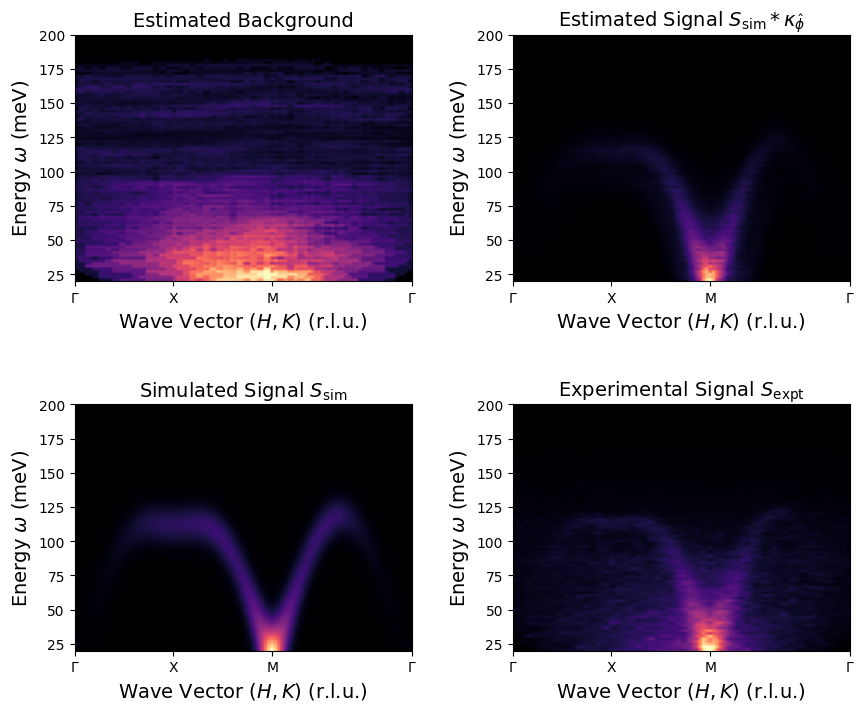

In [44]:
import matplotlib.pyplot as plt

# Choose perceptually uniform colormap suitable for scattering data
# cmap = "viridis"
cmap = "magma"

fig, axes = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0.5, 'wspace': 0.3})

# Panel A: Background component
im0 = axes[0, 0].imshow(
    s_bkg_2d.sum(0),
    origin='lower', aspect='auto', vmax=75, cmap=cmap,
    extent=(0, len(kpts) - 1,
            data_dict['grid']['w_grid'][0], data_dict['grid']['w_grid'][-1])
)
axes[0, 0].set_xticks(kpts_idx)
axes[0, 0].set_xticklabels(kpts_label)
axes[0, 0].set_xlabel("Wave Vector $(H, K)$ (r.l.u.)", fontsize=14)
axes[0, 0].set_ylabel("Energy $\omega$ (meV)", fontsize=14)
axes[0, 0].set_title("Estimated Background", fontsize=14)
# cbar0 = fig.colorbar(im0, ax=axes[0, 0])
# cbar0.set_label("Intensity (a.u.)", fontsize=14)

# Panel B: Signal component
im1 = axes[0, 1].imshow(
    s_sig_2d.sum(0),
    origin='lower', aspect='auto', cmap=cmap,
    extent=(0, len(kpts) - 1,
            data_dict['grid']['w_grid'][0], data_dict['grid']['w_grid'][-1])
)
axes[0, 1].set_xticks(kpts_idx)
axes[0, 1].set_xticklabels(kpts_label)
axes[0, 1].set_xlabel("Wave Vector $(H, K)$ (r.l.u.)", fontsize=14)
axes[0, 1].set_ylabel("Energy $\omega$ (meV)", fontsize=14)
axes[0, 1].set_title(r"Estimated Signal $S_{\mathrm{sim}} * \kappa_{\hat{\phi}}$", fontsize=14)
# cbar1 = fig.colorbar(im1, ax=axes[0, 1])
# cbar1.set_label("Intensity (a.u.)", fontsize=14)

# Panel C: Forward model output
im2 = axes[1, 0].imshow(
    model_sqw.forward_qw(center_pts.to(model_sqw.device)).cpu().sum(0),
    origin='lower', aspect='auto', cmap=cmap,
    extent=(0, len(kpts) - 1,
            data_dict['grid']['w_grid'][0], data_dict['grid']['w_grid'][-1])
)
axes[1, 0].set_xticks(kpts_idx)
axes[1, 0].set_xticklabels(kpts_label)
axes[1, 0].set_xlabel("Wave Vector $(H, K)$ (r.l.u.)", fontsize=14)
axes[1, 0].set_ylabel("Energy $\omega$ (meV)", fontsize=14)
axes[1, 0].set_title(r"Simulated Signal $S_{\mathrm{sim}}$", fontsize=14)
# cbar2 = fig.colorbar(im2, ax=axes[1, 0])
# cbar2.set_label("Intensity (a.u.)", fontsize=14)

# Panel D: Experimental data
im3 = axes[1, 1].imshow(s_exp_2d, origin='lower', aspect='auto', vmax=300, cmap=cmap,
    extent=(0, len(kpts) - 1,
            data_dict['grid']['w_grid'][0], data_dict['grid']['w_grid'][-1]))
axes[1, 1].set_xticks(kpts_idx)
axes[1, 1].set_xticklabels(kpts_label)
axes[1, 1].set_xlabel("Wave Vector $(H, K)$ (r.l.u.)", fontsize=14)
axes[1, 1].set_ylabel("Energy $\omega$ (meV)", fontsize=14)
axes[1, 1].set_title(r"Experimental Signal $S_{\mathrm{expt}}$", fontsize=14)
# cbar3 = fig.colorbar(im3, ax=axes[1, 1])
# cbar3.set_label("Intensity (a.u.)", fontsize=14)

# Optional: Main title
# fig.suptitle("Scattering Signal Decomposition in Reciprocal Space", fontsize=14)

fig.tight_layout()

# # Save in publication-ready format
plt.savefig("../figures/scattering_decomposition_hk.png", dpi=300, bbox_inches='tight')
# plt.savefig("../figures/scattering_decomposition_hk.pdf", bbox_inches='tight')


In [45]:
cmap = "magma"

/tmp/ipykernel_2077040/2511191748.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


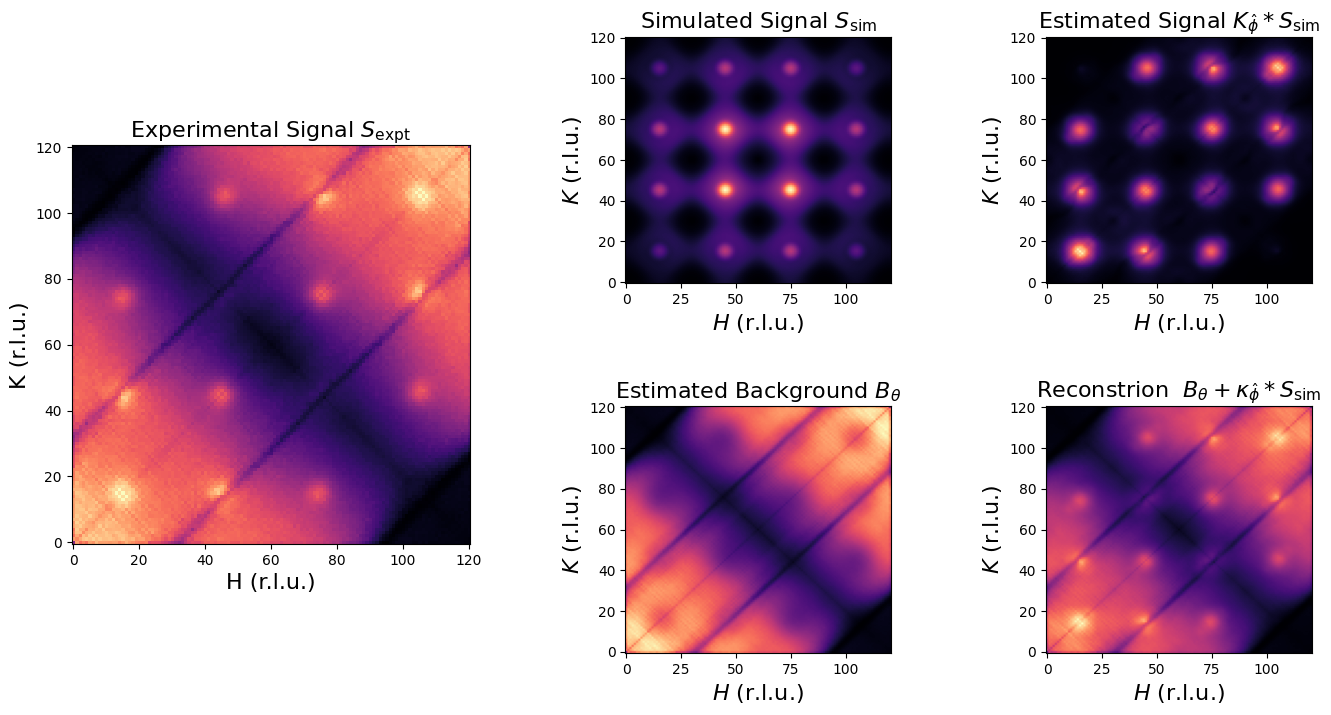

In [46]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Prepare the 2D arrays by reshaping and summing over the last two axes.
S_expt_plot = s_exp_full_2d.sum(-1).sum(-1)
S_sim_plot  = s_sim_full_2d.sum(-1).sum(-1)
S_sig_plot  = s_sig_full_2d.sum(-1).sum(-1)
S_bkg_plot  = s_bkg_full_2d.sum(-1).sum(-1)
recon_plot  = (s_sig_full_2d + s_bkg_full_2d).sum(-1).sum(-1)

# Create a figure with a 2-row x 3-column GridSpec.
# The first column (spanning both rows) will host the large experimental plot.
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(nrows=2, ncols=3, width_ratios=[1.5, 1, 1], wspace=0.5, hspace=0.5)

# Big left panel: Experimental Scattering Data (spanning both rows)
ax_main = fig.add_subplot(gs[:, 0])
im_main = ax_main.imshow(S_expt_plot, origin='lower', aspect='auto', cmap=cmap)
ax_main.set_title(r"Experimental Signal $S_{\mathrm{expt}}$", fontsize=16)
ax_main.set_xlabel("H (r.l.u.)", fontsize=16)
ax_main.set_ylabel("K (r.l.u.)", fontsize=16)
# cbar_main = plt.colorbar(im_main, ax=ax_main, fraction=0.046, pad=0.04)
# cbar_main.set_label("Intensity (a.u.)", fontsize=16)

# Compute the aspect ratio from the image data (height / width)
aspect_ratio = S_expt_plot.shape[0] / S_expt_plot.shape[1]
# Try to set the axis box aspect to preserve the original image proportions
try:
    ax_main.set_box_aspect(aspect_ratio)
except Exception:
    ax_main.set_aspect(aspect_ratio)
# Center the axis content within its allocated grid cell
ax_main.set_anchor('C')

# Top-middle panel: Simulated Scattering Data S_sim
ax1 = fig.add_subplot(gs[0, 1])
im1 = ax1.imshow(S_sim_plot, origin='lower', aspect='auto', cmap=cmap)
ax1.set_title(r"Simulated Signal $S_{\mathrm{sim}}$", fontsize=16)
ax1.set_xlabel("$H$ (r.l.u.)", fontsize=16)
ax1.set_ylabel("$K$ (r.l.u.)", fontsize=16)
# cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
# cbar1.set_label("Intensity (a.u.)", fontsize=16)

# Top-right panel: Estimated Convolved Signal Component
ax2 = fig.add_subplot(gs[0, 2])
im2 = ax2.imshow(S_sig_plot, origin='lower', aspect='auto', cmap=cmap)
ax2.set_title(r"Estimated Signal $K_{\hat{\phi}} * S_{\mathrm{sim}}$", fontsize=16)
ax2.set_xlabel("$H$ (r.l.u.)", fontsize=16)
ax2.set_ylabel("$K$ (r.l.u.)", fontsize=16)
# cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
# cbar2.set_label("Intensity (a.u.)", fontsize=16)

# Bottom-middle panel: Estimated Background Component
ax3 = fig.add_subplot(gs[1, 1])
im3 = ax3.imshow(S_bkg_plot, origin='lower', aspect='auto', cmap=cmap)
ax3.set_title(r"Estimated Background $B_{\theta}$", fontsize=16)
ax3.set_xlabel("$H$ (r.l.u.)", fontsize=16)
ax3.set_ylabel("$K$ (r.l.u.)", fontsize=16)
# cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
# cbar3.set_label("Intensity (a.u.)", fontsize=16)

# Bottom-right panel: Reconstructed $S_{expt}$ = s_bkg + s_sig
ax4 = fig.add_subplot(gs[1, 2])
im4 = ax4.imshow(recon_plot, origin='lower', aspect='auto', cmap=cmap)
ax4.set_title(r"Reconstrion  $B_\theta + \kappa_{\hat{\phi}} * S_{\mathrm{sim}}$", fontsize=16)
ax4.set_xlabel("$H$ (r.l.u.)", fontsize=16)
ax4.set_ylabel("$K$ (r.l.u.)", fontsize=16)
# cbar4 = plt.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)
# cbar4.set_label("Intensity (a.u.)", fontsize=16)

plt.tight_layout()
# # Save the composite figure using filenames based on your configuration.
filename = f'composite_2row3col_nr{config["model_config"]["neighbor_range"]}_bkw{config["loss_bkg_mag_weight"]}_tvw{config["loss_bkg_TV_weight"]}'
plt.savefig(f'../figures/{filename}.png', dpi=300, bbox_inches='tight')
# plt.savefig(f'../figures/{filename}.pdf', bbox_inches='tight')
# plt.show()


/tmp/ipykernel_2077040/312666767.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


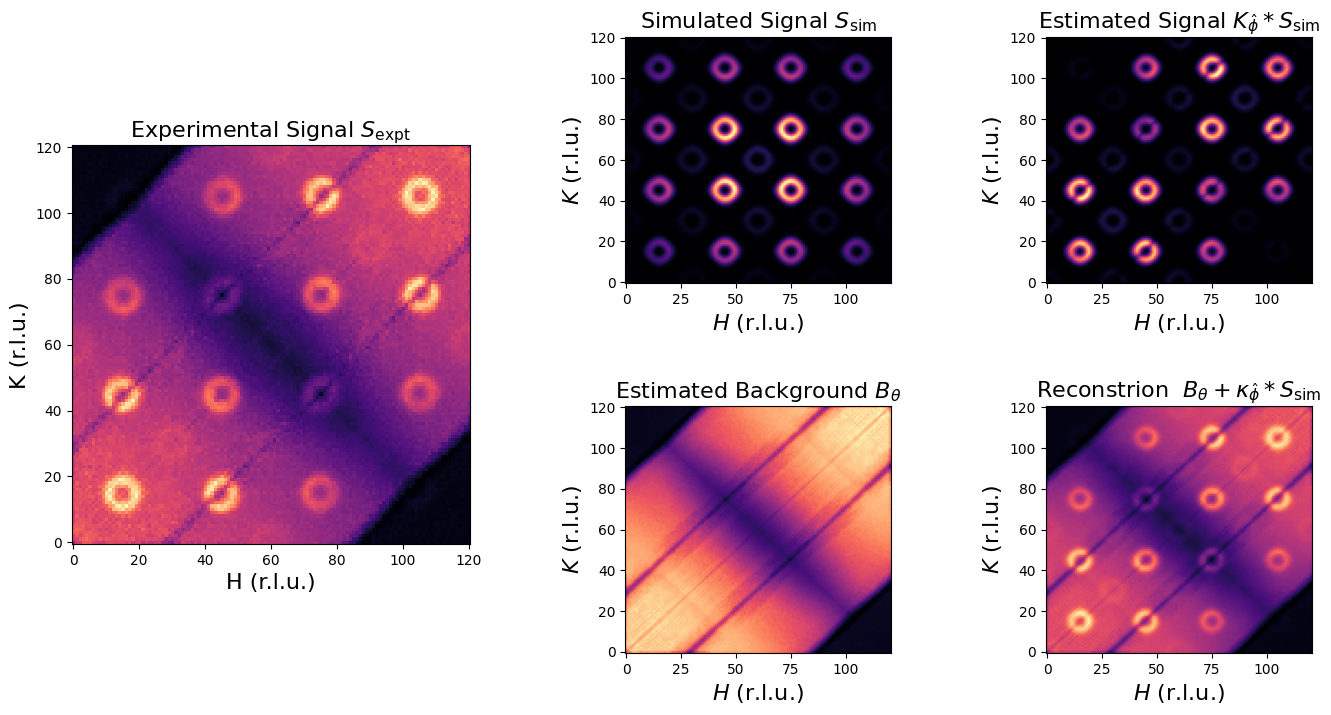

In [35]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Prepare the 2D arrays by reshaping and summing over the last two axes.
S_expt_plot = s_exp_full_2d[:,:,:,20:35].sum(-1).sum(-1)
S_sim_plot  = s_sim_full_2d[:,:,:,20:35].sum(-1).sum(-1)
S_sig_plot  = s_sig_full_2d[:,:,:,20:35].sum(-1).sum(-1)
S_bkg_plot  = s_bkg_full_2d[:,:,:,20:35].sum(-1).sum(-1)
recon_plot  = (s_sig_full_2d + s_bkg_full_2d)[:,:,:,20:35].sum(-1).sum(-1)

# Create a figure with a 2-row x 3-column GridSpec.
# The first column (spanning both rows) will host the large experimental plot.
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(nrows=2, ncols=3, width_ratios=[1.5, 1, 1], wspace=0.5, hspace=0.5)

# Big left panel: Experimental Scattering Data (spanning both rows)
ax_main = fig.add_subplot(gs[:, 0])
im_main = ax_main.imshow(S_expt_plot, origin='lower', aspect='auto', cmap=cmap)
ax_main.set_title(r"Experimental Signal $S_{\mathrm{expt}}$", fontsize=16)
ax_main.set_xlabel("H (r.l.u.)", fontsize=16)
ax_main.set_ylabel("K (r.l.u.)", fontsize=16)
# cbar_main = plt.colorbar(im_main, ax=ax_main, fraction=0.046, pad=0.04)
# cbar_main.set_label("Intensity (a.u.)", fontsize=16)

# Compute the aspect ratio from the image data (height / width)
aspect_ratio = S_expt_plot.shape[0] / S_expt_plot.shape[1]
# Try to set the axis box aspect to preserve the original image proportions
try:
    ax_main.set_box_aspect(aspect_ratio)
except Exception:
    ax_main.set_aspect(aspect_ratio)
# Center the axis content within its allocated grid cell
ax_main.set_anchor('C')

# Top-middle panel: Simulated Scattering Data S_sim
ax1 = fig.add_subplot(gs[0, 1])
im1 = ax1.imshow(S_sim_plot, origin='lower', aspect='auto', cmap=cmap)
ax1.set_title(r"Simulated Signal $S_{\mathrm{sim}}$", fontsize=16)
ax1.set_xlabel("$H$ (r.l.u.)", fontsize=16)
ax1.set_ylabel("$K$ (r.l.u.)", fontsize=16)
# cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
# cbar1.set_label("Intensity (a.u.)", fontsize=16)

# Top-right panel: Estimated Convolved Signal Component
ax2 = fig.add_subplot(gs[0, 2])
im2 = ax2.imshow(S_sig_plot, origin='lower', aspect='auto', cmap=cmap)
ax2.set_title(r"Estimated Signal $K_{\hat{\phi}} * S_{\mathrm{sim}}$", fontsize=16)
ax2.set_xlabel("$H$ (r.l.u.)", fontsize=16)
ax2.set_ylabel("$K$ (r.l.u.)", fontsize=16)
# cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
# cbar2.set_label("Intensity (a.u.)", fontsize=16)

# Bottom-middle panel: Estimated Background Component
ax3 = fig.add_subplot(gs[1, 1])
im3 = ax3.imshow(S_bkg_plot, origin='lower', aspect='auto', cmap=cmap)
ax3.set_title(r"Estimated Background $B_{\theta}$", fontsize=16)
ax3.set_xlabel("$H$ (r.l.u.)", fontsize=16)
ax3.set_ylabel("$K$ (r.l.u.)", fontsize=16)
# cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
# cbar3.set_label("Intensity (a.u.)", fontsize=16)

# Bottom-right panel: Reconstructed $S_{expt}$ = s_bkg + s_sig
ax4 = fig.add_subplot(gs[1, 2])
im4 = ax4.imshow(recon_plot, origin='lower', aspect='auto', cmap=cmap)
ax4.set_title(r"Reconstrion  $B_\theta + \kappa_{\hat{\phi}} * S_{\mathrm{sim}}$", fontsize=16)
ax4.set_xlabel("$H$ (r.l.u.)", fontsize=16)
ax4.set_ylabel("$K$ (r.l.u.)", fontsize=16)
# cbar4 = plt.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)
# cbar4.set_label("Intensity (a.u.)", fontsize=16)

plt.tight_layout()
# # Save the composite figure using filenames based on your configuration.

# # Save the composite figure using filenames based on your configuration.
filename = f'composite_2row3col_clipped_nr{config["model_config"]["neighbor_range"]}_bkw{config["loss_bkg_mag_weight"]}_tvw{config["loss_bkg_TV_weight"]}'
plt.savefig(f'../figures/{filename}.png', dpi=300, bbox_inches='tight')
# plt.savefig(f'../figures/{filename}.pdf', bbox_inches='tight')



Fourier Projection Slice

In [18]:
#Fourier Projection Slice 
proj_sig = np.sum(S_sig_plot, axis=0)
proj_sig_f = np.fft.fftshift(np.fft.fft(proj_sig))
slice_sig2 = np.fft.fftshift(np.fft.fft2(S_sig_plot))[S_sig_plot.shape[0] // 2]

proj_exp = np.sum(S_expt_plot, axis=0)
proj_exp_f = np.fft.fftshift(np.fft.fft(proj_exp))
slice_exp2 = np.fft.fftshift(np.fft.fft2(S_expt_plot))[S_expt_plot.shape[0] // 2]

proj_bkg = np.sum(S_bkg_plot, axis=0)
proj_bkg_f = np.fft.fftshift(np.fft.fft(proj_bkg))
slice_bkg2 = np.fft.fftshift(np.fft.fft2(S_bkg_plot))[S_bkg_plot.shape[0] // 2]

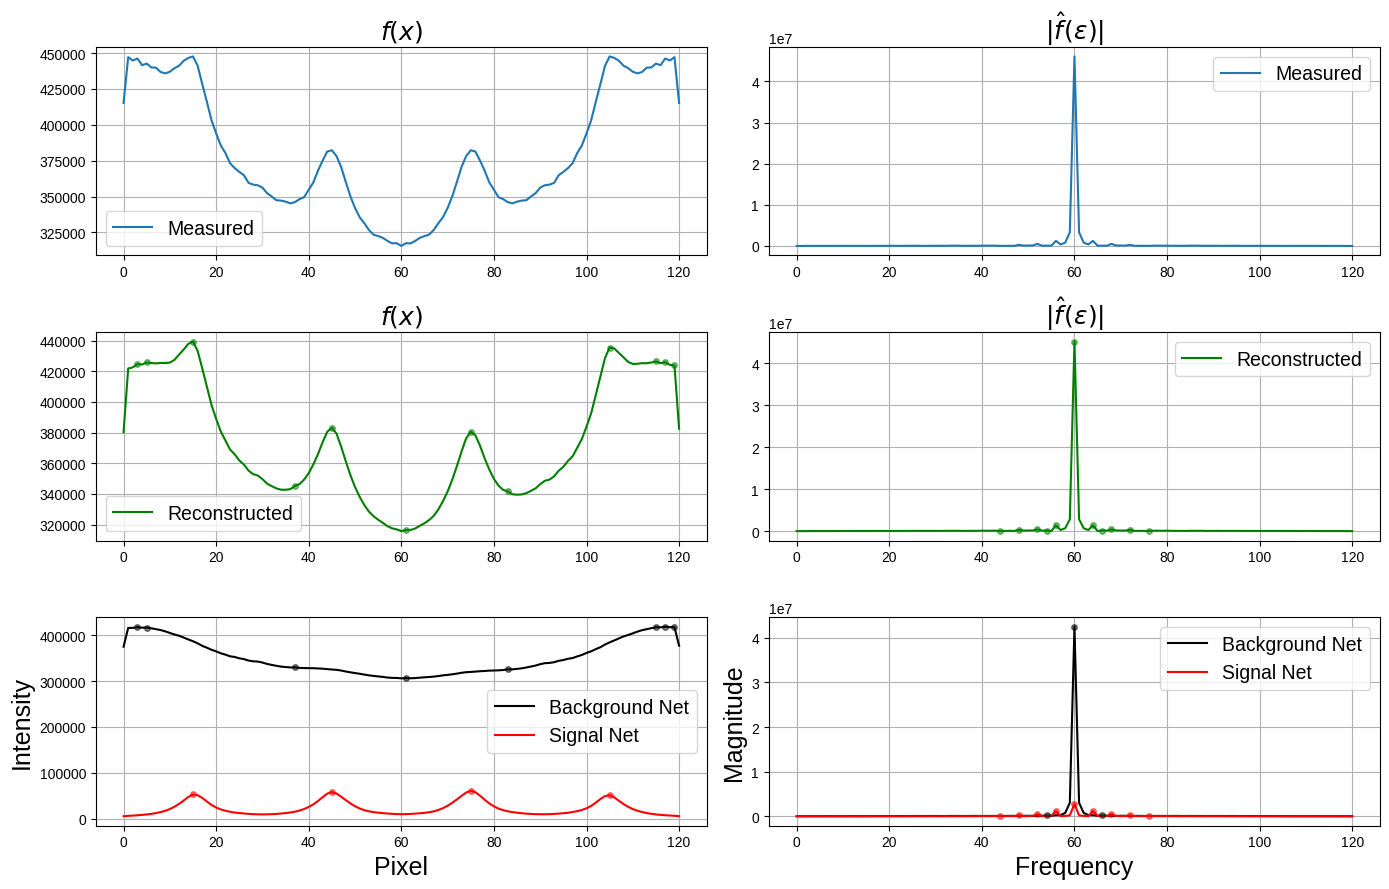

In [19]:
from scipy.signal import find_peaks
fig, axes = plt.subplots(3, 2, figsize=(14, 9))
# --- Truth
axes[0, 0].plot(proj_exp,label ='Measured')
axes[0, 0].set_title(r'$f(x)$', fontsize=18)
axes[0, 0].legend(fontsize=14)
axes[0, 1].plot(np.abs(slice_exp2),label ='Measured')
axes[0, 1].set_title(r'$|\hat f(\epsilon)|$', fontsize=18)
axes[0, 1].legend(fontsize=14)
# --- Top row: proj_bkg + proj_sig
axes[1, 0].plot(proj_bkg + proj_sig,color='green',label ='Reconstructed')
axes[1, 0].set_title(r'$f(x)$', fontsize=18)
axes[1, 0].legend(fontsize=14)
axes[1, 1].plot(np.abs(slice_bkg2 + slice_sig2),color='green',label ='Reconstructed')
axes[1, 1].set_title(r'$|\hat f(\epsilon)|$', fontsize=18)
axes[1, 1].legend(fontsize=14)
# --- Bottom row: proj_bkg and proj_sig separately (black and red)
axes[2, 0].plot(proj_bkg, color='black', label='Background Net')
axes[2, 0].plot(proj_sig, color='red', label='Signal Net')
axes[2, 0].set_xlabel('Pixel', fontsize=18)
axes[2, 0].set_ylabel('Intensity', fontsize=18)
axes[2, 0].legend(fontsize=14)
axes[2, 1].plot(np.abs(slice_bkg2), color='black', label='Background Net')
axes[2, 1].plot(np.abs(slice_sig2), color='red', label='Signal Net')
axes[2, 1].set_xlabel('Frequency', fontsize=18)
axes[2, 1].set_ylabel('Magnitude', fontsize=18)
axes[2, 1].legend( fontsize=14)

for ax in axes.flat:
    ax.grid(True)

### add local maxima

# --- Frequency domain (row 2, col 2) ---
mag_sig = np.abs(slice_sig2)
mag_bkg = np.abs(slice_bkg2)

idx1 = find_peaks(mag_sig, prominence=5e4)[0]
idx2 = find_peaks(mag_bkg, prominence=5e4)[0]
idx_union = np.union1d(idx1, idx2)

# Plot individual maxima
axes[2, 1].plot(idx1, mag_sig[idx1], 'ro', label='Signal Peak', alpha=0.5,markersize=4)
axes[2, 1].plot(idx2, mag_bkg[idx2], 'ko', label='Background Peak', alpha=0.5,markersize=4)

# Plot combined on reconstructed (row 1, col 2)
recon_freq = np.abs(slice_sig2 + slice_bkg2)
axes[1, 1].plot(idx_union, recon_freq[idx_union], 'go', label='Combined Peaks', alpha=0.5,markersize=4)

# --- Spatial domain (row 2, col 1) ---
idx1_spatial = find_peaks(proj_sig, prominence=5)[0]
idx2_spatial = find_peaks(proj_bkg, prominence=5)[0]
idx_union_spatial = np.union1d(idx1_spatial, idx2_spatial)

axes[2, 0].plot(idx1_spatial, proj_sig[idx1_spatial], 'ro', alpha=0.5,markersize=4)
axes[2, 0].plot(idx2_spatial, proj_bkg[idx2_spatial], 'ko', alpha=0.5,markersize=4)

recon_spatial = proj_sig + proj_bkg
axes[1, 0].plot(idx_union_spatial, recon_spatial[idx_union_spatial], 'go', alpha=0.5,markersize=4)
plt.style.use('seaborn-v0_8-white') 
plt.tight_layout()

# filename = f'fourier_projection_slice_nr{config["model_config"]["neighbor_range"]}_bkw{config["loss_bkg_mag_weight"]}_tvw{config["loss_bkg_TV_weight"]}'
# plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
plt.show()